## Imports

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import numpy as np
import ast

## Some helper functions

In [50]:
NOS_elements = ['N', 'O', 'S']
symbol_to_element = {'N': 'nitrogen', 'O': 'oxygen', 'S': 'sulfur'}

# first two rows + S + Se + groups 17 and 18
small_elements = {
    'H', 'He',                                  # First row
    'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',  # Second row
    'S', 'Se',                                  # Sulfur and Selenium
    'Cl', 'Br', 'I', 'At',                      # Group 17 (Halogens)
    'Ar', 'Kr', 'Xe', 'Rn'                      # Group 18 (Noble gases)
}

transition_metals_by_series = {
    '3d': ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn'],
    '4d': ['Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd'],
    '5d': ['Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg'],
    '4f': ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho','Er', 'Tm', 'Yb', 'Lu'],
    '5f': ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
}
transition_metal_series = transition_metals_by_series.keys()
transition_metals = set()
for series, metals in transition_metals_by_series.items():
    transition_metals.update(metals)


def contains_element(formula, element):
    return element in re.findall('([A-Z][a-z]*)', formula)


def num_elements(formula):
    return len(set(re.findall('([A-Z][a-z]*)', formula)))


def get_transition_metal_series(elements):
    transition_metal_series = set()
    for series, metals in transition_metals_by_series.items():
        if any(metal in elements for metal in metals):
            transition_metal_series.add(series)
    return transition_metal_series


def string_to_array(s, sep, shape):
    formatted_str = s.replace('\n', '').replace('[', '').replace(']', '')
    array = np.fromstring(formatted_str, sep=sep)
    return array.reshape(shape)

## Load, filter, reformat, and augment data from CSV

In [3]:
# loading
df = pd.read_csv('icsd_bispectra_lmax_4_crystalnn_cutoff.csv')

# filtering
df = df[~df['site_element'].isin(small_elements)]

# reformatting
df['local_geometry'] = df['local_geometry'].apply(string_to_array, sep=' ', shape=(-1, 3))
df['local_elements'] = df['local_elements'].apply(ast.literal_eval)
df['bispectrum'] = df['bispectrum'].apply(string_to_array, sep=',', shape=(-1))

# augmenting
df['formula'] = df['cif_name'].apply(lambda x: x.split('_')[0])
df['elements'] = df['formula'].apply(lambda x: set(re.findall('([A-Z][a-z]*)', x)))
df['transition_metal_series'] = df['elements'].apply(get_transition_metal_series)
df['small_elements'] = df['elements'].apply(lambda x: x & small_elements) # set intersection

## Basic data statistics

In [4]:
unique_cif_names = set(df.cif_name)
unique_structures = [cif_name.split('_')[0] for cif_name in unique_cif_names]
print(f"Number of unique structures: {len(unique_structures)}")
print(f"Number of unique formulas: {len(df['formula'].unique())}")
print(f"Number of local environments (of non-small elements): {len(df)}")

Number of unique structures: 120652
Number of unique formulas: 110436
Number of local environments (of non-small elements): 400191


100%|██████████| 120652/120652 [00:00<00:00, 329704.45it/s]


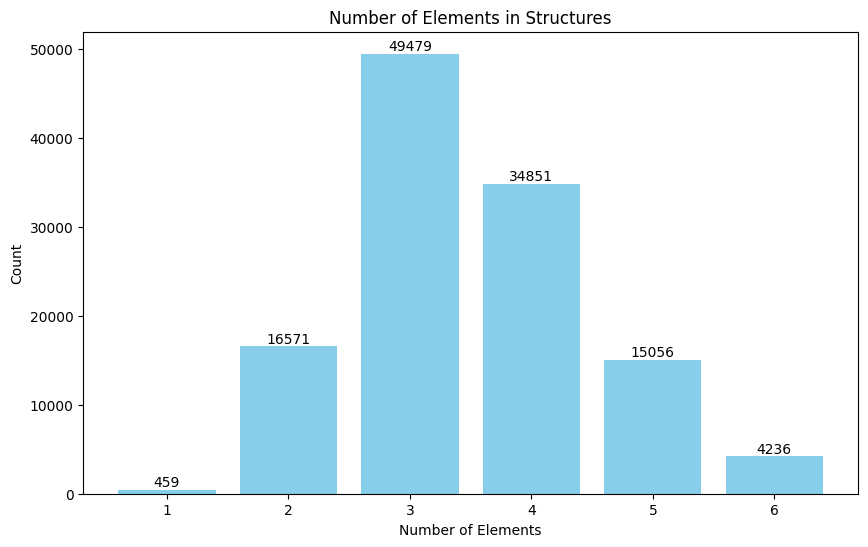

In [5]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each number of elements
num_elements_counts = {}
for formula in tqdm(unique_structures):
    count = num_elements(formula)
    if count not in num_elements_counts:
        num_elements_counts[count] = 1
    else:
        num_elements_counts[count] += 1

# Prepare data for plotting
elements = list(num_elements_counts.keys())
counts = [num_elements_counts[element] for element in elements]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(elements, counts, color='skyblue')
plt.xlabel('Number of Elements')
plt.ylabel('Count')
plt.title('Number of Elements in Structures')
plt.xticks(elements)

# Adding counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.show()

## Analysis

In [6]:
spectra_list = df['bispectrum'].tolist()
pca = PCA(n_components=2)
principal_components = pca.fit_transform(spectra_list)
df['pca1'] = principal_components[:,0]
df['pca2'] = principal_components[:,1]
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by 1st Principal Component: {explained_variance[0]*100:.2f}%")
print(f"Variance explained by 2nd Principal Component: {explained_variance[1]*100:.2f}%")


Variance explained by 1st Principal Component: 91.90%
Variance explained by 2nd Principal Component: 6.52%


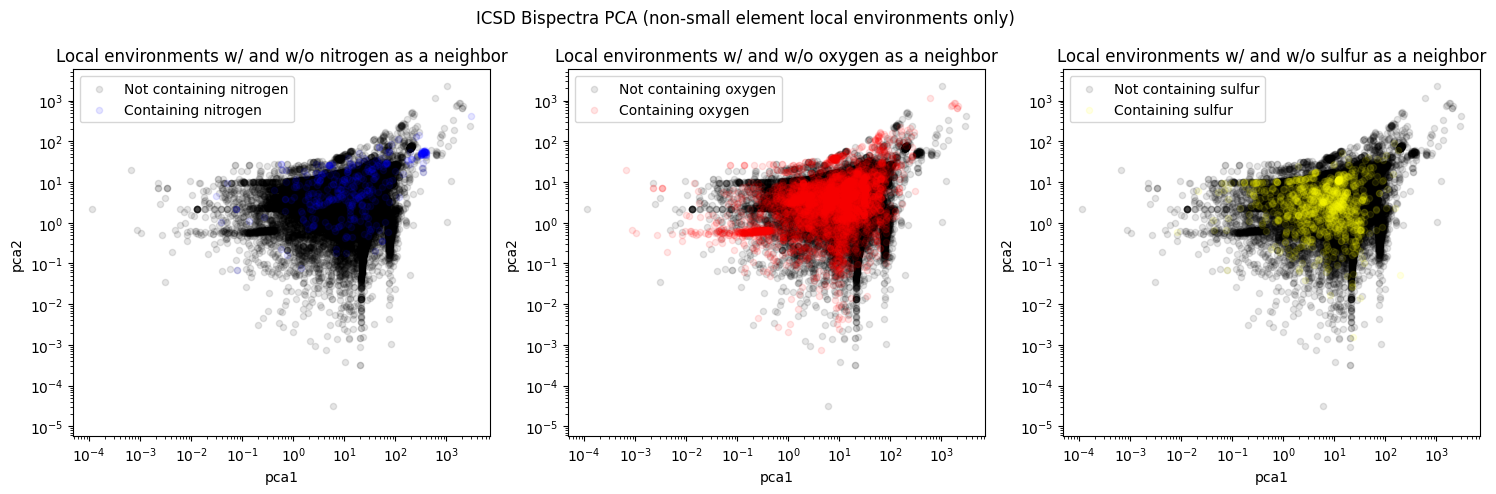

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ICSD Bispectra PCA (non-small element local environments only)')

colors = ['blue', 'red', 'yellow']

for ax, NOS_element, color in zip(axs, NOS_elements, colors):
    filter = df['local_elements'].apply(lambda x: NOS_element in x)
    included = df[filter]
    excluded = df[~filter]
    ax.set_title(f'Local environments w/ and w/o {symbol_to_element[NOS_element]} as a neighbor')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    excluded.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='black', alpha=0.1, label=f'Not containing {symbol_to_element[NOS_element]}')
    included.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color=color, alpha=0.1, label=f"Containing {symbol_to_element[NOS_element]}")
    ax.legend()

plt.tight_layout()
plt.show()

ICSD Bispectra PCA (non-small element local environments only) by Electronic Series


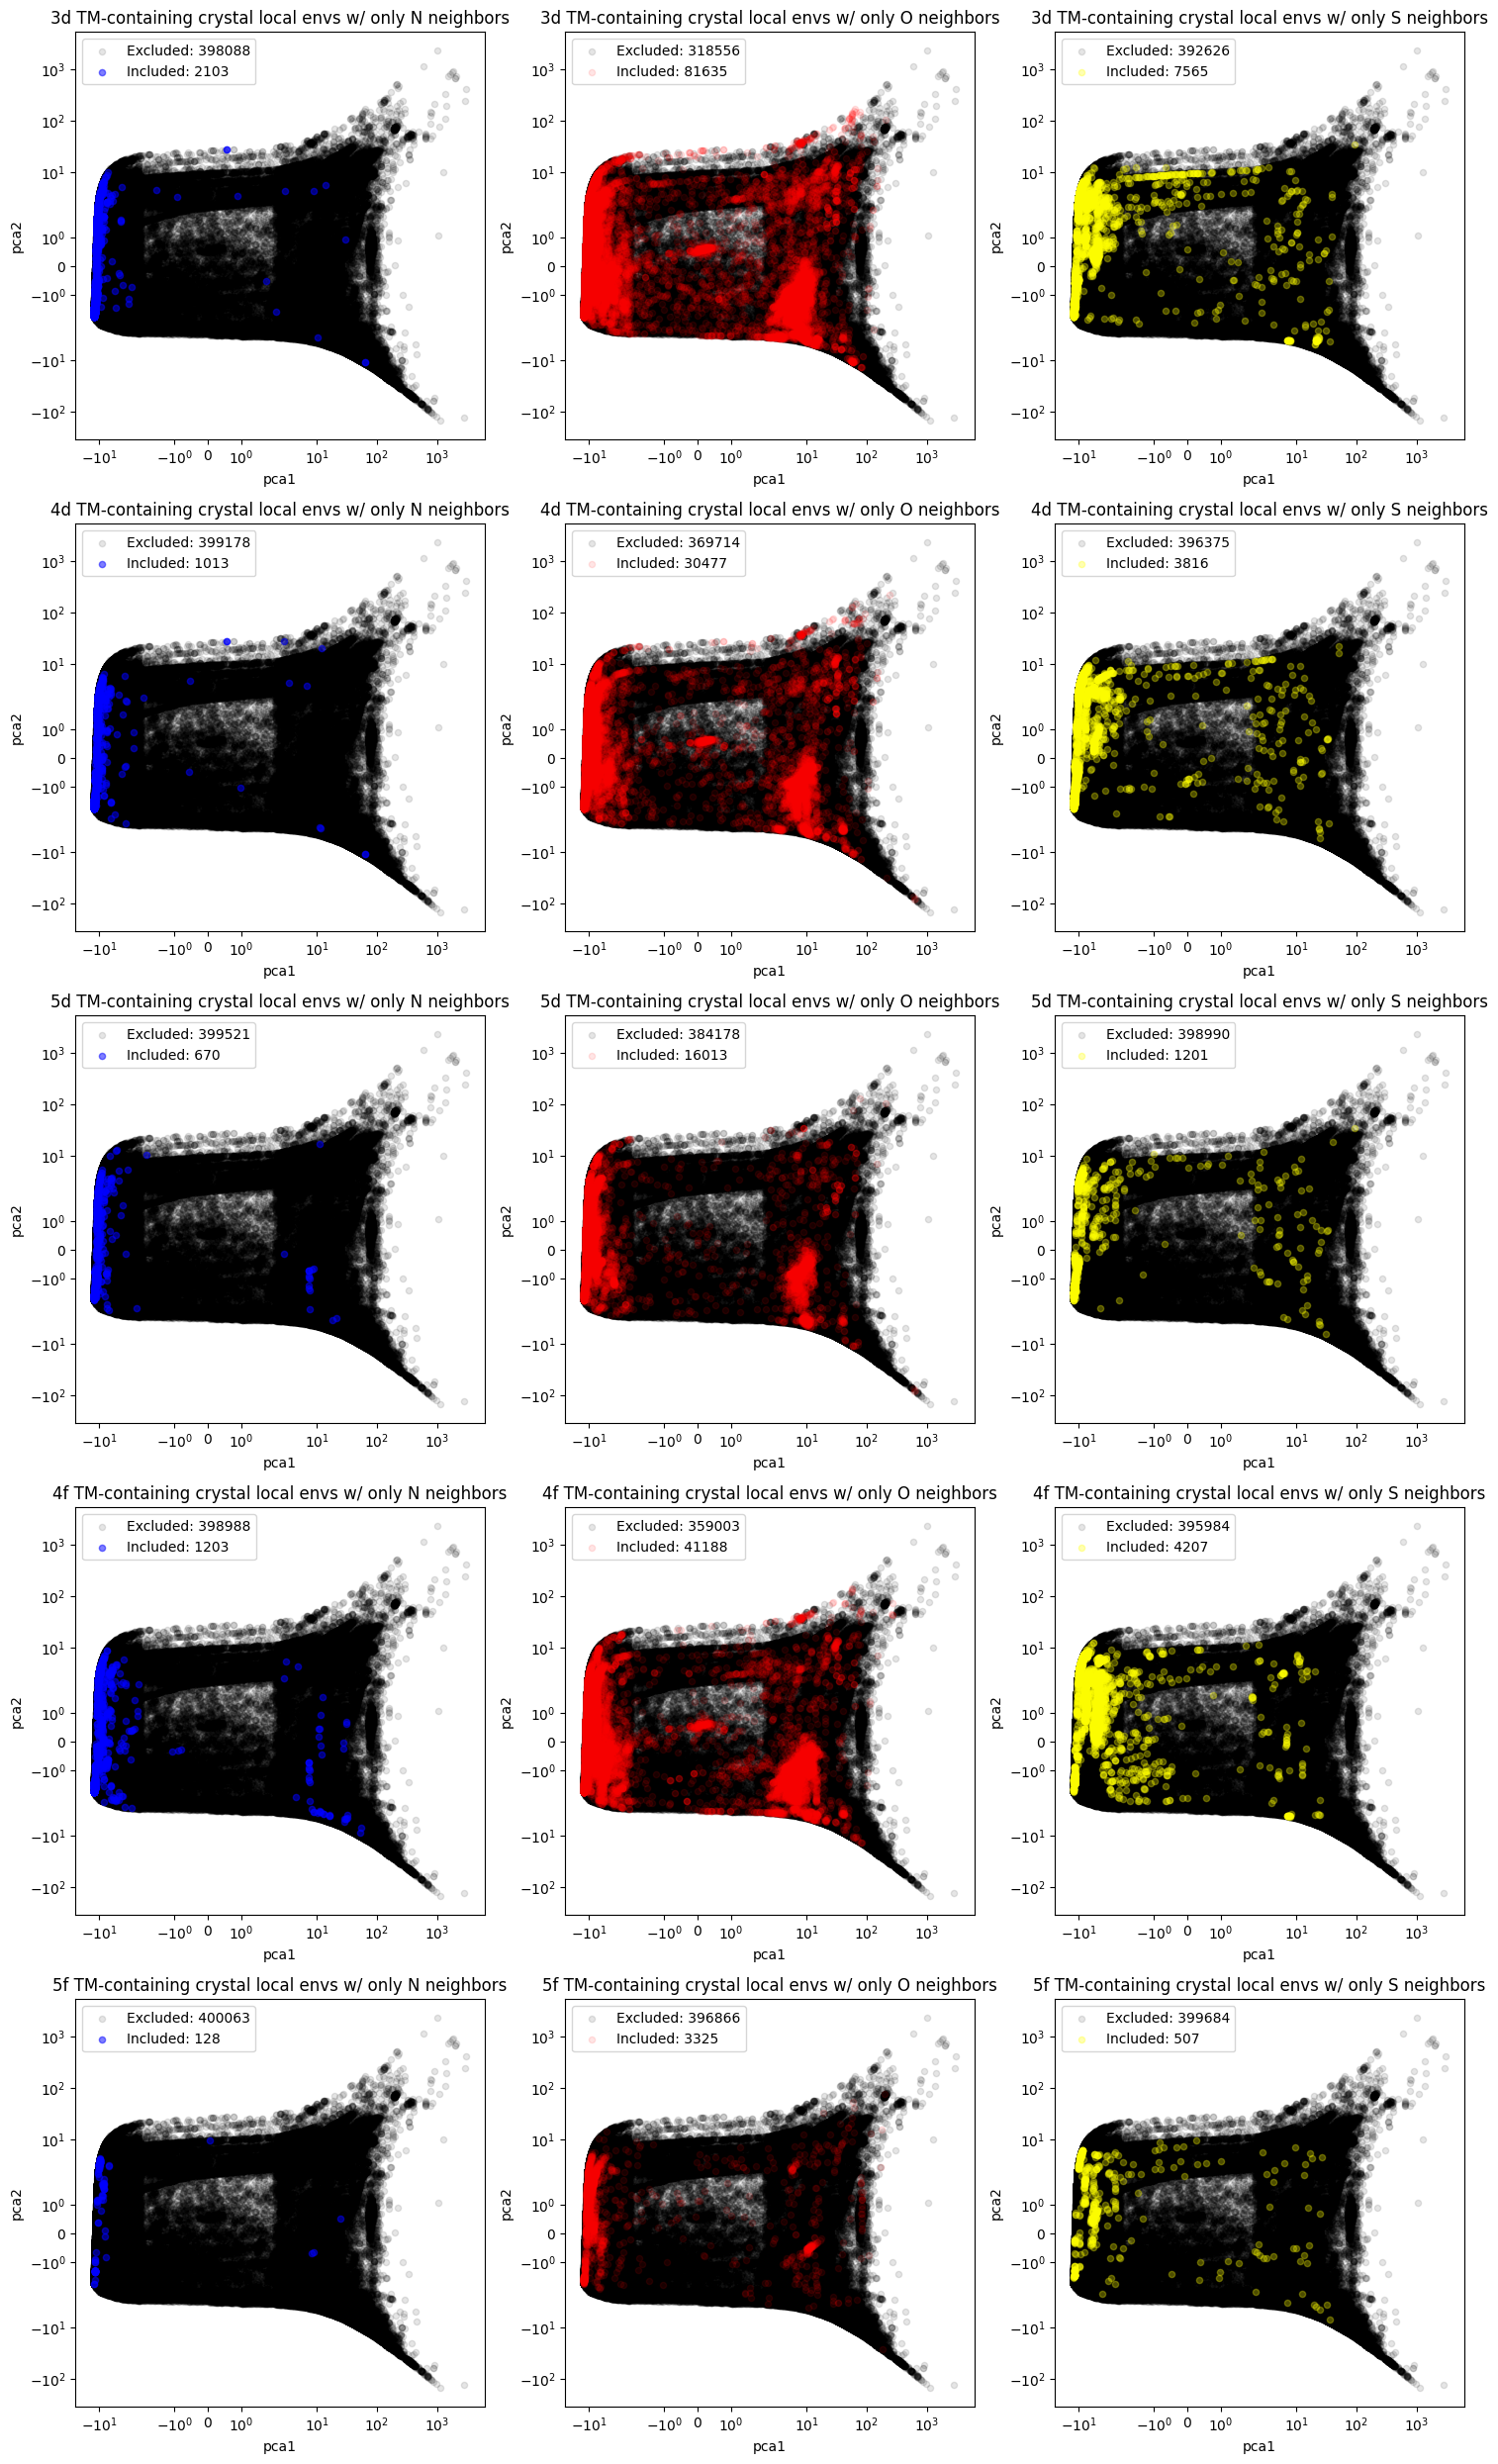

In [75]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
print('ICSD Bispectra PCA (non-small element local environments only) by Electronic Series')

colors = ['blue', 'red', 'yellow']
opacities = {'N': 0.5, 'O': 0.1, 'S': 0.3}
for i, NOS_element in enumerate(NOS_elements):
    for j, series in enumerate(transition_metal_series):
        ax = axs[j, i]
        NOS_filter = df['local_elements'].apply(lambda x: (NOS_element in x) and (len(set(x)) == 1))
        series_filter = df['transition_metal_series'].apply(lambda x: series in x)
        filter = NOS_filter & series_filter 
        included = df[filter]
        excluded = df[~filter]
        ax.set_title(f'{series} TM-containing crystal local envs w/ only {NOS_element} neighbors')
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        excluded.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='black', alpha=0.1, label=f'Excluded: {excluded.shape[0]}')
        included.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color=colors[i], alpha=opacities[NOS_element], label=f"Included: {included.shape[0]}")
        ax.legend()

plt.tight_layout()
plt.show()

ICSD Bispectra PCA (non-small element local environments only) by Electronic Series


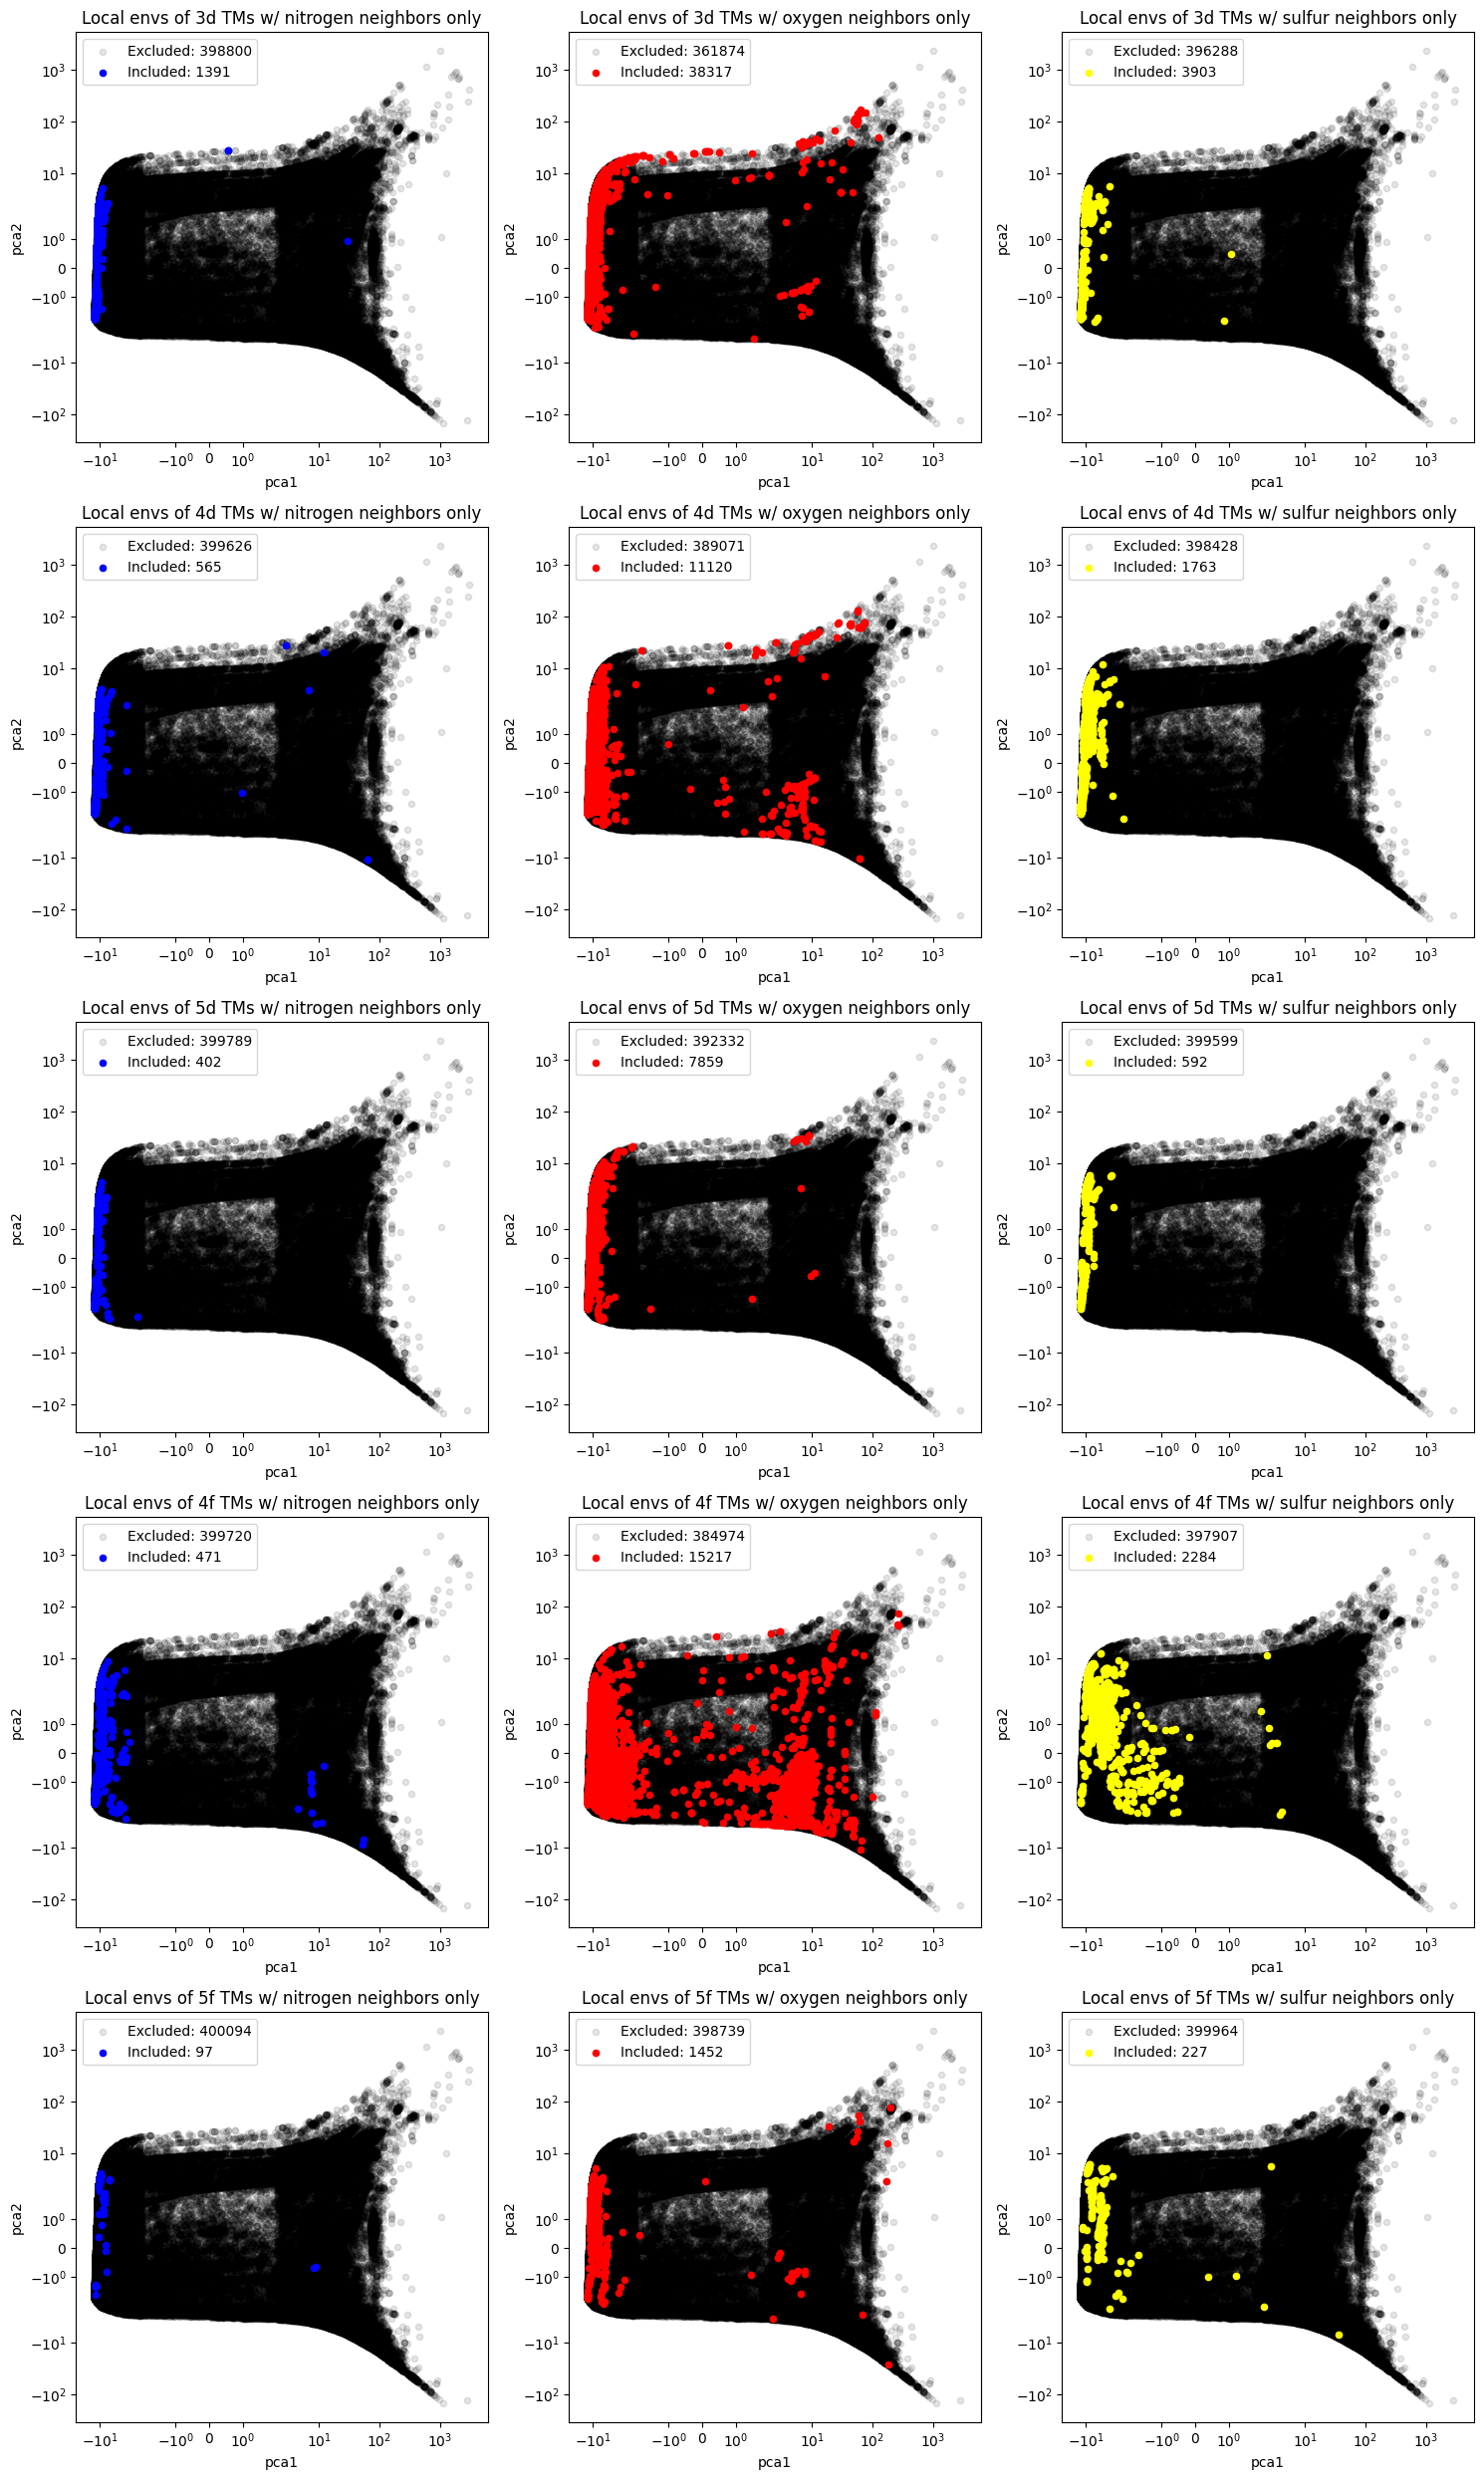

In [76]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
print('ICSD Bispectra PCA (non-small element local environments only) by Electronic Series')

colors = ['blue', 'red', 'yellow']
opacities = {'N': 1, 'O': 1, 'S': 1}
for i, NOS_element in enumerate(NOS_elements):
    for j, series in enumerate(transition_metal_series):
        ax = axs[j, i]
        NOS_filter = df['local_elements'].apply(lambda x: (NOS_element in x) and (len(set(x)) == 1))
        series_filter = df['site_element'].apply(lambda x: x in transition_metals_by_series[series])
        filter = NOS_filter & series_filter 
        included = df[filter]
        excluded = df[~filter]
        if NOS_element == 'N' and series == '5d':
            df_temp = included.copy()
        ax.set_title(f'Local envs of {series} TMs w/ {symbol_to_element[NOS_element]} neighbors only')
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        excluded.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='black', alpha=0.1, label=f'Excluded: {excluded.shape[0]}')
        included.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color=colors[i], alpha=opacities[NOS_element], label=f"Included: {included.shape[0]}")
        ax.legend()

plt.tight_layout()
plt.show()

In [67]:
df_temp

,cif_name,site_index,site_element,local_geometry,local_elements,bispectrum,formula,elements,transition_metal_series,small_elements,pca1,pca2
2496,ReN_216.cif,0,Re,"[[-1.1367, -1.1367, 1.1367], [-1.1367, 1.1367,...","[N, N, N, N]","[0.2461330145597458, 0.0, 5.67850954013732e-17...",ReN,"{N, Re}",{5d},{N},-11.824041,-1.482917
3056,WN_225.cif,0,W,"[[-1.3321095e-16, 2.1754999, 1.3321095e-16], [...","[N, N, N, N, N, N]","[1.120731234550476, 3.501723513936447e-34, 1.6...",WN,"{N, W}",{5d},{N},-10.601691,1.762017
3569,(Hf0.91Zr0.09)N_225.cif,0,Hf,"[[1.3813404e-16, -2.2558999, -1.3813404e-16], ...","[N, N, N, N, N, N]","[1.2496365308761597, 3.904487597380251e-34, 1....",(Hf0.91Zr0.09)N,"{Zr, N, Hf}","{4d, 5d}",{N},-10.427385,2.166289
8068,W(N3)6_147.cif,0,W,"[[1.3797851, -0.8578664, -1.0767303], [0.05304...","[N, N, N, N, N, N]","[0.8418014049530029, 0.0034635832998901606, 0....",W(N3)6,"{N, W}",{5d},{N},-10.989823,0.776134
13794,Ta5N4.79O1.81_193.cif,0,Ta,"[[1.7276299, -0.0014953613, -1.274317], [-0.86...","[N, N, N, N, N, N]","[1.076902985572815, 2.0483692731365286e-14, 0....",Ta5N4.79O1.81,"{O, N, Ta}",{5d},"{N, O}",-10.662101,1.611045
...,...,...,...,...,...,...,...,...,...,...,...,...
822262,CeWN3_6.cif,5,W,"[[0.38452435, -0.05987036, 1.9683677], [1.1157...","[N, N, N, N, N, N]","[0.8977566361427307, 0.00035411209682933986, 0...",CeWN3,"{N, Ce, W}","{4f, 5d}",{N},-10.903679,1.057796
827473,IrN2_14.cif,0,Ir,"[[-0.2242477, -1.92888, 0.46000195], [0.419048...","[N, N, N, N, N, N]","[0.9170928001403809, 0.008831974118947983, 0.0...",IrN2,"{Ir, N}",{5d},{N},-10.895975,0.930091
831550,Li2Hf(CN2)3_167.cif,12,Hf,"[[-0.91371852, 1.5826735, 1.185607], [0.913776...","[N, N, N, N, N, N]","[1.1252100467681885, 4.7489481214241136e-17, 0...",Li2Hf(CN2)3,"{N, C, Li, Hf}",{5d},"{N, Li, C}",-10.600060,1.721633
833686,W2.56N4_194.cif,0,W,"[[1.4349999, -0.82849765, 1.3639998], [1.43499...","[N, N, N, N, N, N]","[1.0760396718978882, 2.0478217933910707e-15, 0...",W2.56N4,"{N, W}",{5d},{N},-10.906760,-0.941262


/tmp/ipykernel_1593369/2951715287.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


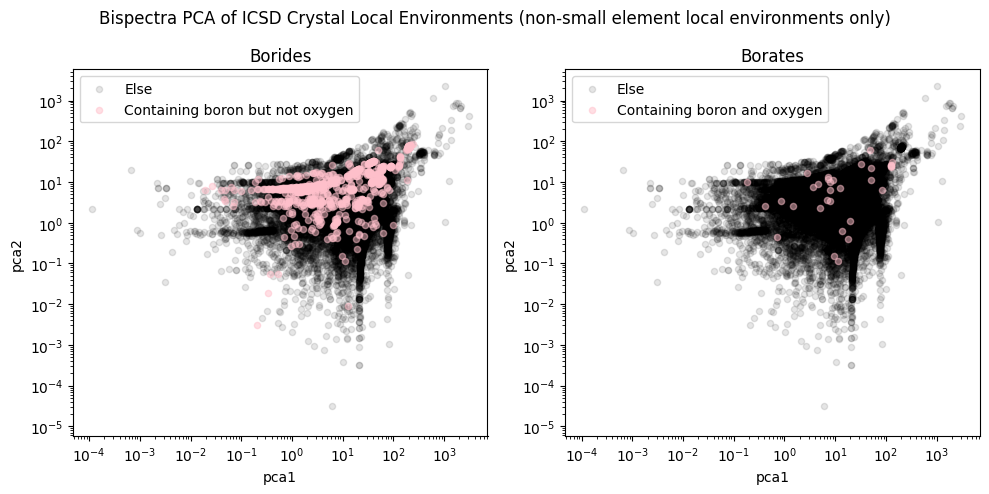

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Bispectra PCA of ICSD Crystal Local Environments (non-small element local environments only)')

boron_filter = df['local_elements'].apply(lambda x: 'B' in x)
oxygen_filter = df['local_elements'].apply(lambda x: 'O' in x)

ax = axs[0]
included = df[boron_filter]
excluded = df[~boron_filter]
ax.set_title(f'Borides')
ax.set_xscale('log')
ax.set_yscale('log')
excluded.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='black', alpha=0.1, label='Else')
included.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='pink', alpha=0.5, label='Containing boron but not oxygen')
ax.legend()

ax = axs[1]
included = df[boron_filter & oxygen_filter]
excluded = df[~(boron_filter & oxygen_filter)]
ax.set_title(f'Borates')
ax.set_xscale('log')
ax.set_yscale('log')
excluded.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='black', alpha=0.1, label='Else')
included.plot(ax=ax, kind='scatter', x='pca1', y='pca2', color='pink', alpha=0.5, label='Containing boron and oxygen')
ax.legend()

plt.tight_layout()
plt.show()

In [39]:
def get_elements(formula):
    import re
    element_counts = {}
    # Handle groups like (OH)2 by expanding them first
    expanded_formula = re.sub(r'\(([A-Za-z]+)\)(\d+)', lambda m: ''.join([m.group(1)] * int(m.group(2))), formula)
    elements_with_multiplicity = re.findall('([A-Z][a-z]*)(\\d*)', expanded_formula)
    for element, multiplicity in elements_with_multiplicity:
        multiplicity = int(multiplicity) if multiplicity else 1
        if element in element_counts:
            element_counts[element] += multiplicity
        else:
            element_counts[element] = multiplicity
    return element_counts

from collections import Counter

In [43]:
ternaries = df[df['formula'].apply(lambda x: num_elements(x) == 3)]
ternaries["element_counts"] = ternaries['formula'].apply(get_elements)
perovskite_candidates = ternaries[ternaries['element_counts'].apply(lambda x: Counter(x.values()) == Counter([1, 1, 3]))]
perovskite_candidates.head()



/tmp/ipykernel_1593369/467417173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ternaries["element_counts"] = ternaries['formula'].apply(get_elements)


,cif_name,site_index,site_element,local_geometry,local_elements,bispectrum,formula,elements,transition_metal_series,small_elements,pca1,pca2,element_counts
262,Pb(NiO3)_161.cif,0,Ni,"[[1.779411, 0.2501426, -1.0075326], [-1.106335...","[O, O, O, O, O, O]","[0.9994361400604248, 0.02430972084403038, 2.53...",Pb(NiO3),"{O, Pb, Ni}",{3d},{O},-10.798473,1.052010,"{'Pb': 1, 'Ni': 1, 'O': 3}"
263,Pb(NiO3)_161.cif,6,Pb,"[[-1.1063354, -1.7190682, 0.7411413], [-0.9355...","[O, O, O, O, O, O]","[1.2271912097930908, 0.15154898166656494, 0.00...",Pb(NiO3),"{O, Pb, Ni}",{3d},{O},-10.637723,0.303009,"{'Pb': 1, 'Ni': 1, 'O': 3}"
452,HfSrS3_62.cif,0,Sr,"[[0.6698451, 0.0, 2.848432], [1.924923, 1.9626...","[S, S, S, S, S, S, S, S]","[7.759016513824463, 0.3962015211582184, 0.3537...",HfSrS3,"{S, Sr, Hf}",{5d},{S},-4.020378,0.100665,"{'Hf': 1, 'Sr': 1, 'S': 3}"
453,HfSrS3_62.cif,4,Hf,"[[0.12691784, 2.429, 0.6650822], [-0.12691808,...","[S, S, S, S, S, S]","[1.7697209119796753, 3.901137971148126e-14, 0....",HfSrS3,"{S, Sr, Hf}",{5d},{S},-9.724346,3.794759,"{'Hf': 1, 'Sr': 1, 'S': 3}"
959,Pb(TiO3)_47.cif,0,Ti,"[[1.9375, 0.0, 1.1863766e-16], [-1.9375, 0.0, ...","[O, O, O, O, O, O]","[0.8896481394767761, 0.0, 0.002040891209617257...",Pb(TiO3),"{Pb, O, Ti}",{3d},{O},-10.913991,1.038481,"{'Pb': 1, 'Ti': 1, 'O': 3}"


In [65]:
unique_candidates = set()
for _, perovskite_candidate in perovskite_candidates.iterrows():
    element_counts = perovskite_candidate.element_counts
    B_site_candidates = [element for element, count in element_counts.items() if count == 1]
    if B_site_candidates[0] in transition_metals and B_site_candidates[1] in transition_metals:
        unique_candidates.add(perovskite_candidate.formula)

print(len(unique_candidates))
print(list(unique_candidates)[:10])



654
['PrCrGe3', 'EuPtGe3', 'LaRhGa3', 'LaRhGe3', '(SmS)1.19TaS2', 'LuFeO3', 'SmMnO3', 'Al3CePd', 'LaYbS3', 'Gd(CrO3)']
